# **CycleGAN 실습**

## 학습목표

Unsupervised Image-to-Image Translation을 최초로 제시한 CycleGAN 알고리즘에 대해 이해해 본다.

**목차(context)**
- CycleGAN Dataset 알아보기
- CycleGAN Training
- CycleGAN Testing

> 이번 실습에서는 CycleGAN 알고리즘을 직접 구현하는 실습을 진행해본다. 2017년, Image-to-Image Translation 분야에서는 매우 획기적인 연구인 CycleGAN이 발표되었다. CycleGAN은 최초로 Unsupervised Image-to-Image Translation 개념을 적용한 연구 결과물인데, 위에서 제시한 pix2pix를 개발한 연구실에서 이어서 발표된 논문이다. Paired Dataset을 사용해서 Image-to-Image Translation을 할 수 있다면 좋겠지만, 위에서 언급했듯이 Paired된 Data를 구하기 어렵기 때문에 현업에서 사용되기 어려운 점이 있다. 이 논문에서는 Cycle Consistency라는 개념을 적용하여 문제를 해결하였는데, 쉽게 요약하면 특징점을 매칭시켜 새로운 이미지를 생성하는 과정을 학습시키고, 다시 원래대로 이미지를 복귀하는 기술이다.



### CycleGAN


![CycleGAN](https://github.com/yunjey/mnist-svhn-transfer/blob/master/gif/cyclegan.png?raw=true)

> CycleGAN의 가장 큰 핵심은 Cycle Consistency로, Input Image에서 Output Image로 mapping하는 forward consistency와 그 반대의 과정 (생성한 Output Image를 Input Image로 변환하는 과정) 을 포함한 backward consistency로 구성되어 있다. 즉, Input을 의도한 Output으로 바꾸되 이 Output을 다시 원래의 Input으로 되돌리라는 것이며 모델의 구조는 위 사진과 같다.

## 1. Import Packages

> 먼저, 필요한 package를 아래 코드를 사용하여 import 한다.

In [1]:
# PyTorch 관련 된 라이브러리.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # optimization에 관한 모듈.
import torchvision # 이미지 관련 전처리, pretrained된 모델, 데이터 로딩에 관한 패키지.
import torchvision.datasets as datasets
import torchvision.transforms as T # 이미지 전처리 모듈.
from torch.utils import data

# 기타 필요한 라이브러리.
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import warnings
warnings.filterwarnings(action='ignore')

## 2. DataLoader 불러오기

CycleGAN의 경우 두 가지 서로 다른 도메인의 데이터(MNIST, SVHN)가 필요하다. 모델이 트레이닝 된 이후에는 우리는 MNIST를 SVHN으로 바꾸거나 SVHN 데이터를 MNIST로 바꿀 수 있다.

> torchvision.dataset 에는 우리가 많이 사용하는 데이터들을 쉽게 사용할 수 있도록 되어 있다. Machine Learning 에서 기본적인 실습 데이터로 사용되는 MNIST 데이터를 사용해 보겠다.

> DataLoader 는 데이터와 Batch Size의 정보를 바탕으로 매 iteration 마다 주어진 데이터를 원하는 Batch Size 만큼 반환해주는 Iterator이다.

> * Practical Guide : **Batch Size 는 어느정도가 좋은가? -- 클 수록 좋다는 여러 경험이 있다.** 하지만 GPU memeory 사이즈 한계에 의해 기본적으로 Batch Size 가 커질 수록 학습에 사용되는 GPU memory 사이즈가 크다. (Activation map을 저장해야 하기 때문이다.) 기본적으로 2의 배수로 저장하는 것이 좋다.(Bit size 관련)

In [2]:
def MNIST_DATA(root='./data/', download=True, batch_size=32, num_worker=4):
    print ("[+] Get the MNIST DATA")

    transform = T.Compose([T.Resize(32), # 32 x 32로 변환
                           T.ToTensor()])

    mnist_train = datasets.MNIST(root = root,  #root 는 데이터의 저장 위치
                                 train = True, #Train 은 이 데이터가 train 데이터인지 아닌지에 대한 정보
                                 transform = transform,
                                 download = True)  # 데이터를 다운로드 할지 여부
    mnist_test = datasets.MNIST(root = root,
                                train = False,  # Test Data를 가져오기에 Train =False 를 줘야 함.
                                transform = transform,
                                download = True)

    trainDataLoader = data.DataLoader(dataset = mnist_train,  # DataSet은 어떤 Data를 제공해 줄지에 대한 정보. 여기서는 Training DATA를 제공.
                                      batch_size = batch_size, # batch size 정보를 꼭 줘야 한다. 한 Batch 당 몇 개의 Data 를 제공할지에 대한 정보.
                                      shuffle =True, # Training의 경우 Shuffling 을 해주는 것이 성능에 지대한 영향을 끼친다. 꼭 True 를 줘야 한다.
                                      num_workers = num_worker) # num worker의 경우 데이터를 로드하는데 worker를 얼마나 추가하겠는가에 대한 정보이다.

    testDataLoader = data.DataLoader(dataset = mnist_test, # Test Data Loader 이므로 Test Data를 인자로 전달해준다.
                                     batch_size = batch_size, # 마찬가지로 Batch size 를 넣어준다.
                                     shuffle = False, # shuffling 이 굳이 필요하지 않으므로 false를 준다.
                                     num_workers = num_worker) #
    print ("[+] Finished loading data & Preprocessing")
    return mnist_train, mnist_test, trainDataLoader, testDataLoader

> The Street View House Numbers(SVHN) 데이터 셋은 길거리에서 집 번호들을 찍은 Dataset이다. SVHN은 MNIST와 마찬가지로 숫자 데이터셋이나 구조가 MNIST 와 같이 단순하지 않고 색깔 등이 있는 Real 이미지 이다.

In [3]:
def SVHN_DATA(root='./data/', download =True, batch_size=32, num_worker=4):

    print ("[+] Get the SVHN DATA")
    transform = T.Compose([T.Resize(32), # 32 x 32로 변환
                           T.ToTensor()])

    svhn_train = datasets.SVHN(root = root,  #root 는 데이터의 저장 위치.
                               split = 'train', # SVHN 데이터의 경우 'split' argument로 train/test를 지정
                               transform = transform, # 얻어낸 데이터를 Resize 해주고, Tensor로 변환
                               download = True)  # 데이터를 다운로드 할지 여부

    svhn_test = datasets.SVHN(root = root,
                              split = 'test',  # SVHN 데이터의 경우 'split' argument로 train/test를 지정
                              transform = transform,
                              download = True)

    trainDataLoader = data.DataLoader(dataset = svhn_train,  # DataSet은 어떤 Data를 제공해 줄지에 대한 정보이다. 여기서는 Training DATA를 제공한다.
                                      batch_size = batch_size, # batch size 정보를 꼭 줘야 한다. 한 Batch 당 몇 개의 Data 를 제공할지에 대한 정보이다.
                                      shuffle =True, # Training의 경우 Shuffling 을 해주는 것이 성능에 지대한 영향을 끼친다. 꼭 True 를 줘야 한다.
                                      num_workers = num_worker) # num worker의 경우 데이터를 로드하는데 worker를 얼마나 추가하겠는가에 대한 정보이다.

    testDataLoader = data.DataLoader(dataset = svhn_test, # Test Data Loader 이므로 Test Data를 인자로 전달해준다.
                                     batch_size = batch_size, # 마찬가지로 Batch size 를 넣어준다.
                                     shuffle = False, # shuffling 이 굳이 필요하지 않으므로 false를 준다.
                                     num_workers = num_worker) #
    print ("[+] Finished loading data & Preprocessing")
    return svhn_train, svhn_test, trainDataLoader, testDataLoader

In [4]:
# Dataloader들을 불러온다.
mnist_trainset, mnist_testset, mnist_trainloader, mnist_testloader = MNIST_DATA(batch_size = 4, num_worker=4)
svhn_trainset, svhn_testset, svhn_trainloader, svhn_testloader = SVHN_DATA(batch_size = 4, num_worker=4)

[+] Get the MNIST DATA
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15832159.98it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 480247.44it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4314609.20it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9015867.85it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

[+] Finished loading data & Preprocessing
[+] Get the SVHN DATA


100%|██████████| 182040794/182040794 [00:14<00:00, 12229406.24it/s]


100%|██████████| 64275384/64275384 [00:02<00:00, 23381790.41it/s]


[+] Finished loading data & Preprocessing


## 3. MNIST, SVHN 데이터 확인

In [ ]:
def show_images_by_class(dataset, cmap=None):
    ''' 각 데이터 셋에서 0-9 숫자를 찾아서 출력 해본다. '''
    per_class_index = []
    try:
        labels = dataset.targets # dataset의 레이블 정보를 배운다.
    except:
        labels = dataset.labels

    for idx in range(10):
        try:
            per_class_index += [(labels == idx).nonzero()[1].item()]
        except:
            per_class_index += [(labels == idx).nonzero()[0][1].item()]

    images = dataset.data[torch.Tensor(per_class_index).long()]

    plt.figure(figsize=(16,160)) # 세로 사이즈 20, 가로 사이즈 20*10

    for a in range(1, 11):
        plt.subplot(1, 10, a)
        try:
            plt.imshow(images[a-1], cmap)
        except:
            plt.imshow(images[a-1].transpose(1,2,0), cmap)
        plt.xticks([])
        plt.yticks([])
    plt.show()

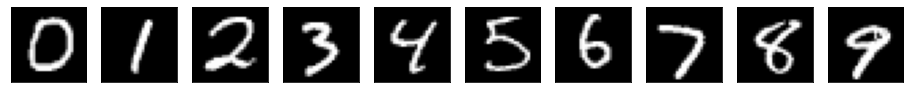

In [ ]:
show_images_by_class(mnist_testset, plt.cm.gray)

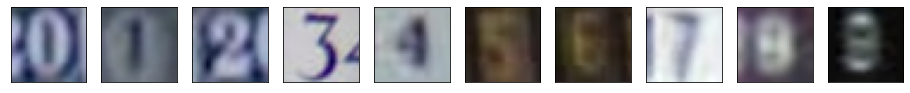

In [ ]:
show_images_by_class(svhn_testset)

출력 결과와 같이 Dataset 구성을 확인할 수 있다.

## 4. Generator, Discriminator

> 코드 단순화를 위한 함수들을 정의해 준다.

> 먼저, conv 함수는 코드 단순화를 위한 convolution block 생성을 위한 함수이다. Conv → Batchnorm → Activation function 으로 이어지는 일련의 레이어를 생성한다.

In [5]:
def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    layers = []

    # Conv 과정
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))

    # Batchnorm 과정
    if bn:
        layers.append(nn.BatchNorm2d(c_out))

    # Activation 과정
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass

    return nn.Sequential(*layers)

> deconv 함수는 코드 단순화를 위한 deconvolution block 생성을 위한 함수이다. Deconv → Batchnorm → Activation function 으로 이어지는 일련의 레이어를 생성한다.

In [6]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    layers = []

    # Deconv 과정
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))

    # Batchnorm 과정
    if bn:
        layers.append(nn.BatchNorm2d(c_out))

    # Activation 과정
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass

    return nn.Sequential(*layers)

> Generator와 Discriminator를 선언해 준다. 이 때 MNIST는 흑백 이미지이므로 채널이 1이라는 점과 SVHN은 컬러 이미지이므로 채널이 3이라는 것에 주의한다.

In [7]:
class Generator(nn.Module):
    """ Generator 클래스 """
    def __init__(self, in_dim=1, out_dim=3):
        super(Generator, self).__init__()
        # encoding 블록
        self.conv1 = conv(in_dim, 64, 4)
        self.conv2 = conv(64, 64*2, 4)

        # 중간 블록
        self.conv3 = conv(64*2, 64*2, 3, 1, 1)
        self.conv4 = conv(64*2, 64*2, 3, 1, 1)

        # decoding 블록
        self.deconv1 = deconv(64*2, 64, 4)
        self.deconv2 = deconv(64, out_dim, 4, bn=False, activation='tanh')

    def forward(self, x):
        out = self.conv1(x)      # (B, 64, 16, 16)
        out = self.conv2(out)    # (B, 128, 8, 8)

        out = self.conv3(out)    # (B, 128, 8, 8)
        out = self.conv4(out)    # (B, 128, 8, 8)

        out = self.deconv1(out)  # (B, 64, 16, 16)
        out = self.deconv2(out)  # (B, out_dim, 32, 32)
        return out


class Discriminator(nn.Module):
    """ Discriminator 클래스 """
    def __init__(self, in_dim=1):
        super(Discriminator, self).__init__()
        self.conv1 = conv(in_dim, 64, 4, bn=False)
        self.conv2 = conv(64, 64*2, 4)
        self.conv3 = conv(64*2, 64*4, 4)
        self.fc = conv(64*4, 1, 4, 1, 0, bn=False, activation='none')

    def forward(self, x):
        out = self.conv1(x)    # (B, 64, 16, 16)
        out = self.conv2(out)  # (B, 128, 8, 8)
        out = self.conv3(out)  # (B, 256, 4, 4)
        out = self.fc(out).squeeze()
        out = torch.sigmoid(out)
        return out

## 5. 학습을 위한 사전 모델/optimizer 선언 & 기타준비


- `G_ms`: MNIST 이미지에서 SVHN 이미지로 Translation 시 활용되는 Generator.
- `G_sm`: `G_ms` 에서 생성한 SVHN 이미지를 다시 MNIST 이미지로 복귀시키는 Translation 시 활용되는 Generator. (Cycle Consistency)
- `D_m`: MNIST Dataset에 대한 Discriminator. **생성된 MNIST 이미지**가 Real인지, Fake인지 검증함.
- `D_s`: SVHN Dataset에 대한 Discriminator. **생성된 SVHN 이미지**가 Real인지, Fake인지 검증함.

In [8]:
# 모델 선언 및 train모드로 만들어 준다.
G_ms = Generator(in_dim=1, out_dim=3).train().cuda()
G_sm = Generator(in_dim=3, out_dim=1).train().cuda()
D_m = Discriminator(in_dim=1).train().cuda()
D_s = Discriminator(in_dim=3).train().cuda()

# Optimizer 선언
g_optimizer = optim.Adam(list(G_ms.parameters()) + list(G_sm.parameters()), lr=0.0002, betas=(0.5, 0.99))
d_optimizer = optim.Adam(list(D_m.parameters()) + list(D_s.parameters()), lr=0.0002, betas=(0.5, 0.99))

# Fixed된 이미지를 프린팅하는 함수
def show_images(images):
    print_list = []
    for i in range(2):
        print_list += [images[0][i], images[1][i], images[2][i]]

    for i in range(2):
        print_list += [images[3][i], images[4][i], images[5][i]]
    plt.figure(figsize=(8,14)) # 세로 사이즈 40, 가로 사이즈 20*3

    for a in range(1, 7):
        target_img = print_list[a-1]
        if target_img.shape[0] == 3:
            target_img = target_img.transpose(1, 2, 0)
            cmap = None
        else:
            target_img = target_img.transpose(1, 2, 0).squeeze()
            cmap = plt.cm.gray
        plt.subplot(4, 3, a)
        plt.imshow(target_img, cmap)
        plt.xticks([])
        plt.yticks([])
    for a in range(7, 13):
        target_img = print_list[a-1]
        if target_img.shape[0] == 3:
            target_img = target_img.transpose(1, 2, 0)
            cmap = None
        else:
            target_img = target_img.transpose(1, 2, 0).squeeze()
            cmap = plt.cm.gray
        plt.subplot(4, 3, a)
        plt.imshow(target_img, cmap)
        plt.xticks([])
        plt.yticks([])
    plt.show()

## 6. Training CycleGAN

> 여기서의 loss는 크게 4가지로 나누어 진다.

- D: Real images들을 1로 분류하기 위한 loss (d_real_loss)
- D: Fake images들을 0로 분류하기 위한 loss (d_fake_loss)
- G: D를 속이는 Fake images들을 만들기 위한 loss (D에서 1로 분류함)(g_loss (1))
- G: 다시 돌아 갔을 때 reconstruction을 위한 cycle loss (g_loss (2))

Step[1000/50000], d_real_loss: 0.0000, d_fake_loss: 0.0000, g_loss: 1.0532


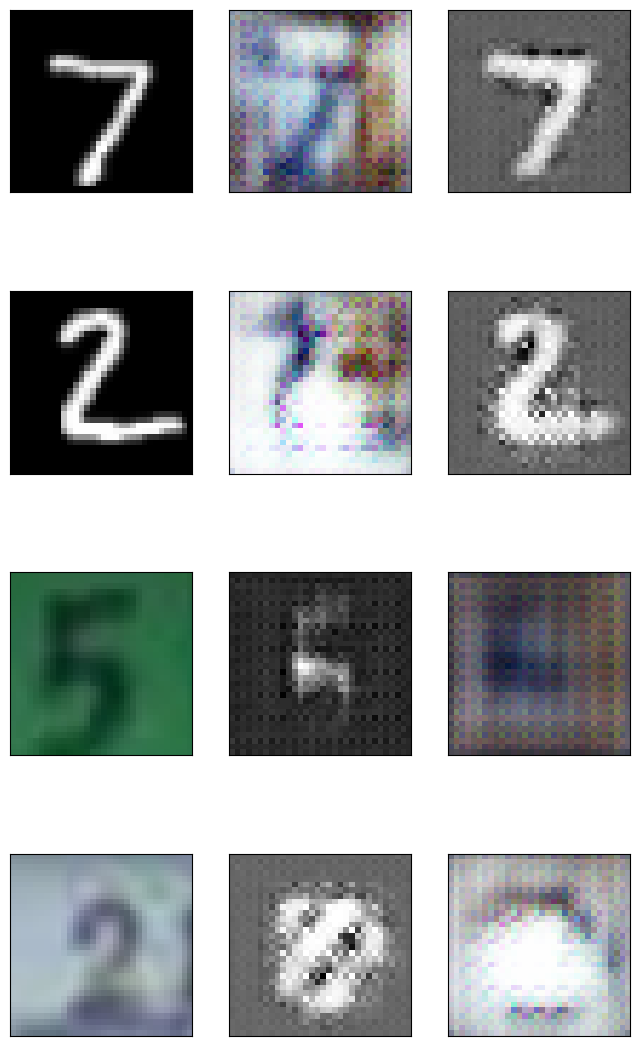

Step[2000/50000], d_real_loss: 0.0000, d_fake_loss: 0.0000, g_loss: 1.0294


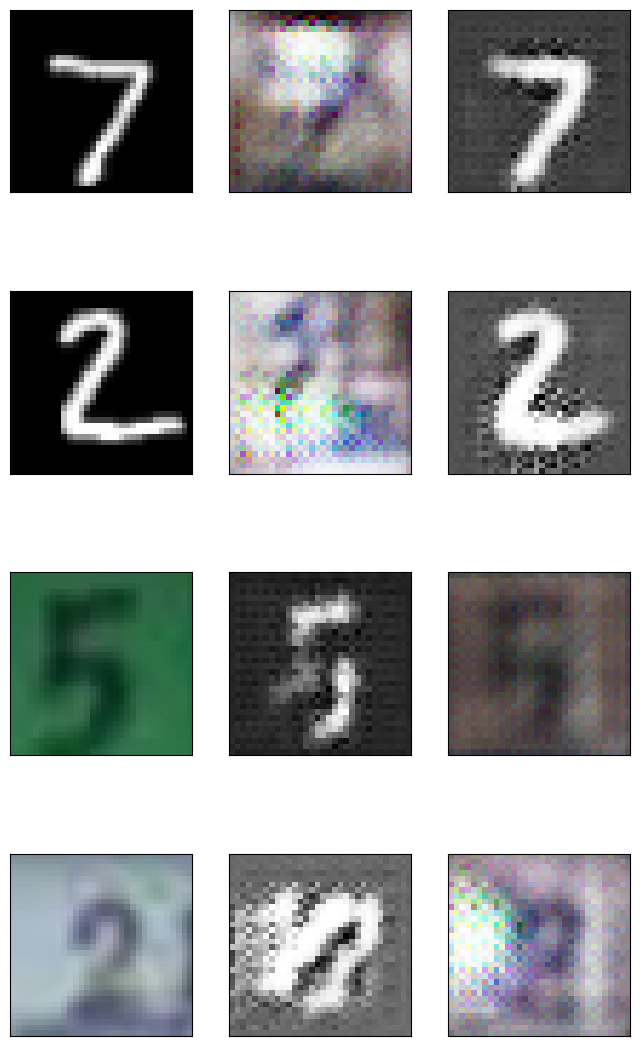

Step[3000/50000], d_real_loss: 0.0000, d_fake_loss: 0.0000, g_loss: 1.0681


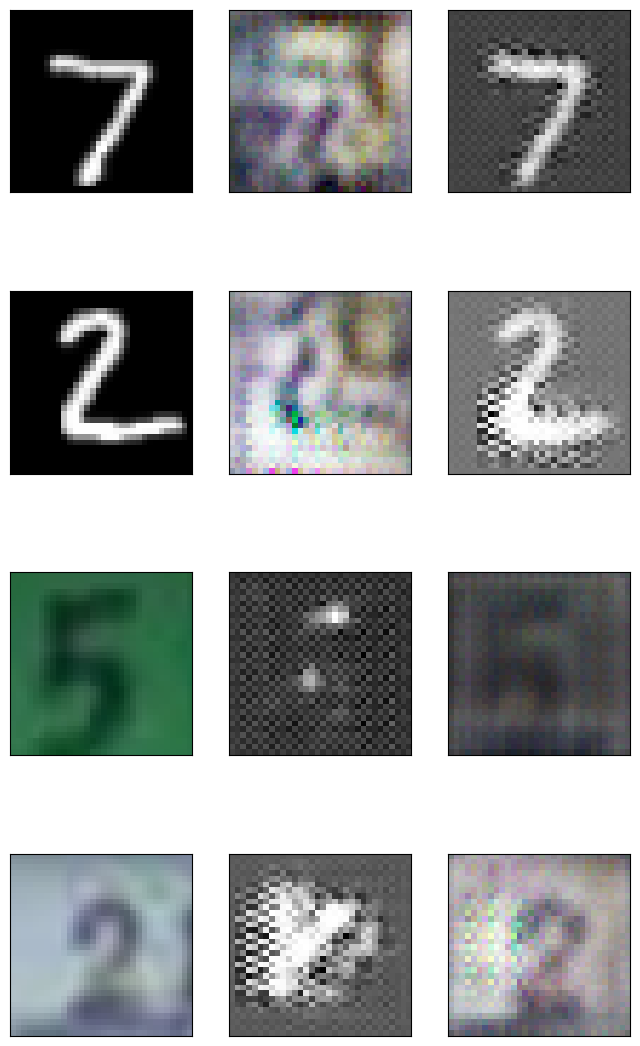

Step[4000/50000], d_real_loss: 0.0000, d_fake_loss: 0.0000, g_loss: 1.0152


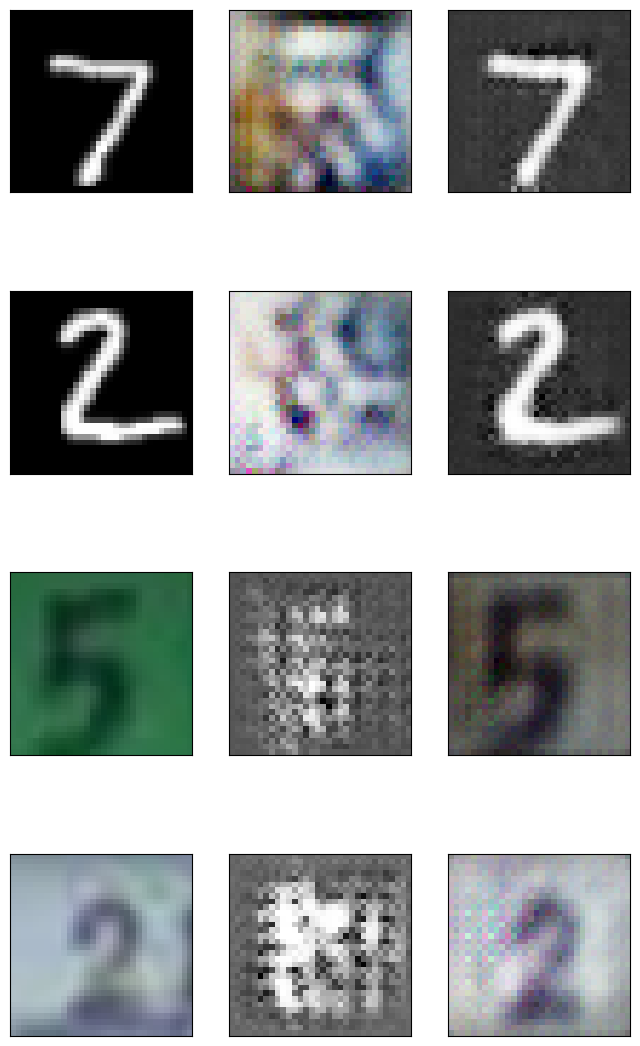

Step[5000/50000], d_real_loss: 0.0000, d_fake_loss: 0.0000, g_loss: 1.0065


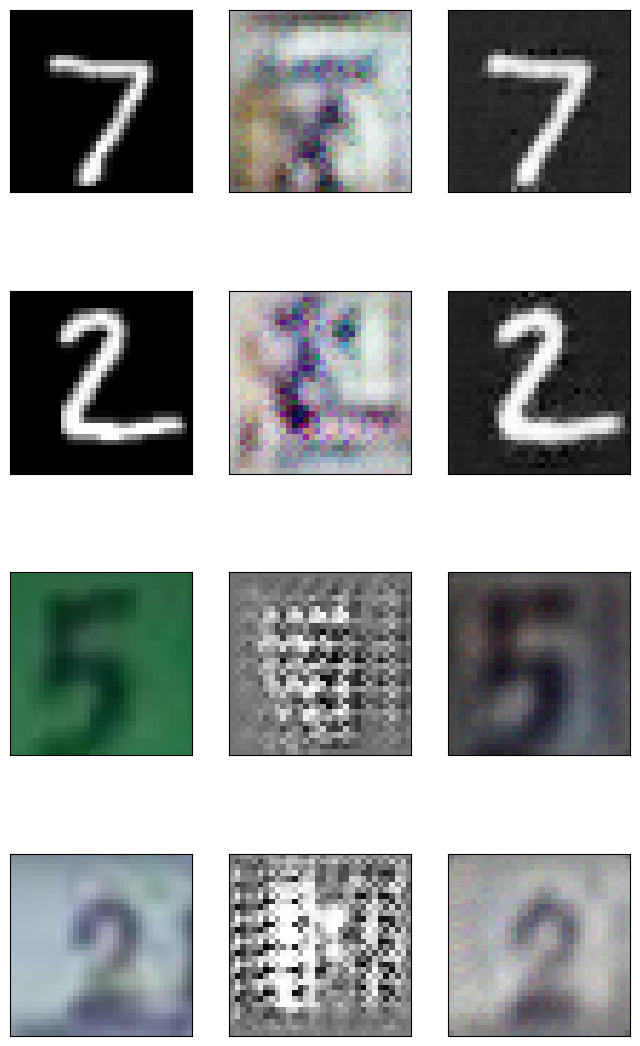

Step[6000/50000], d_real_loss: 0.0000, d_fake_loss: 0.0000, g_loss: 1.0287


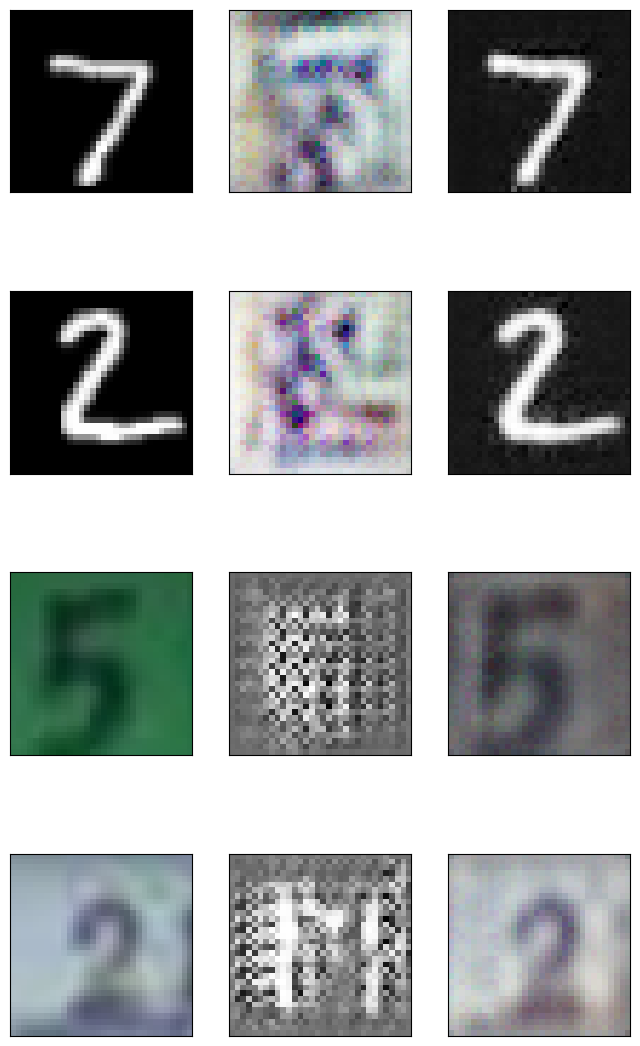

Step[7000/50000], d_real_loss: 0.0000, d_fake_loss: 0.0000, g_loss: 1.0101


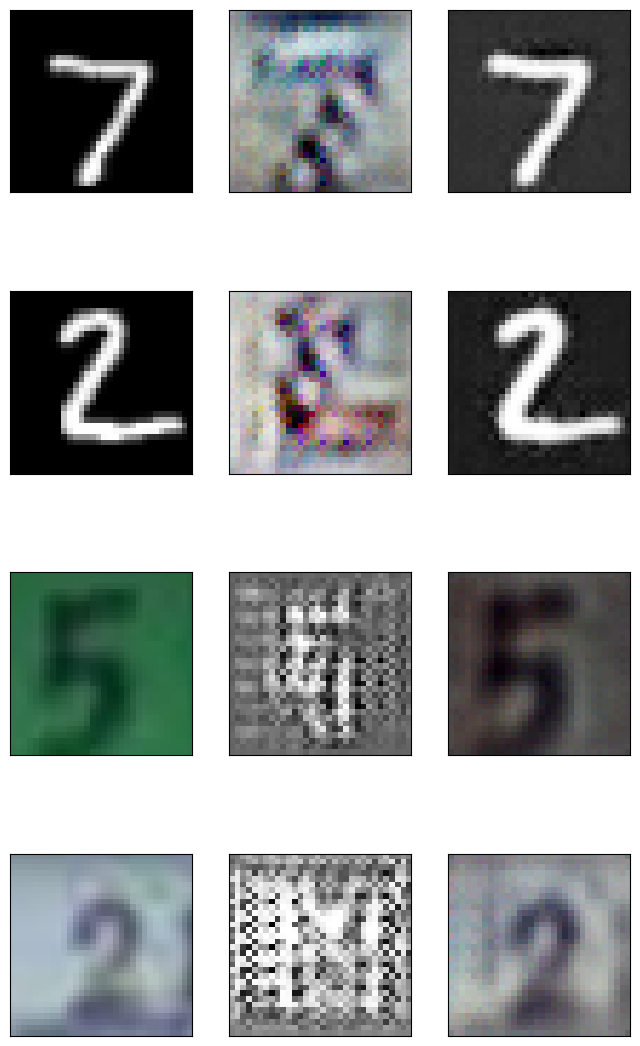

Step[8000/50000], d_real_loss: 0.1829, d_fake_loss: 0.0000, g_loss: 1.0404


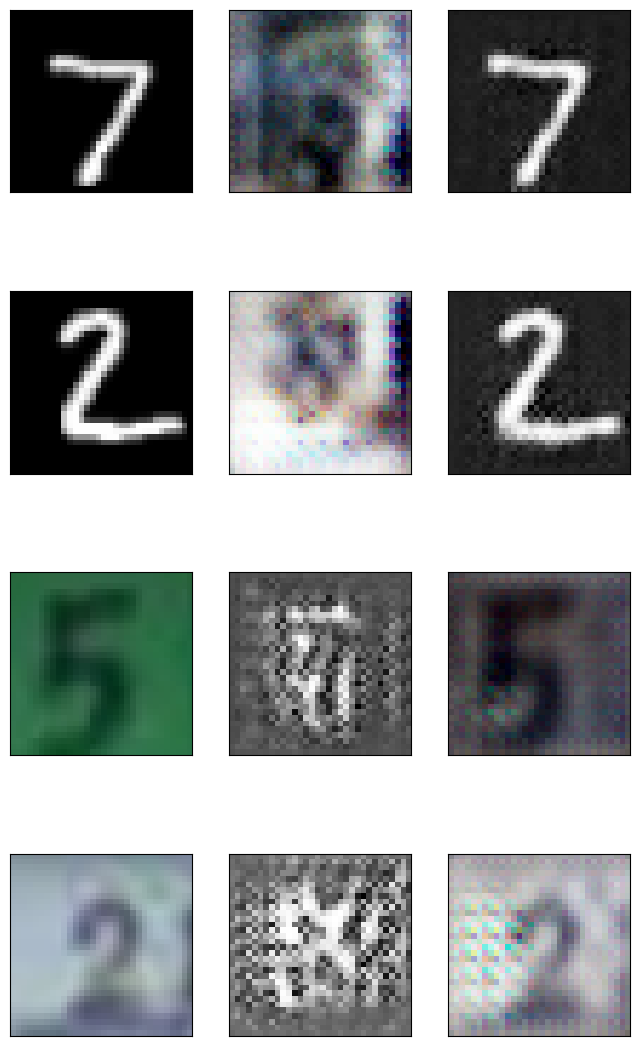

Step[9000/50000], d_real_loss: 0.0000, d_fake_loss: 0.0000, g_loss: 1.0184


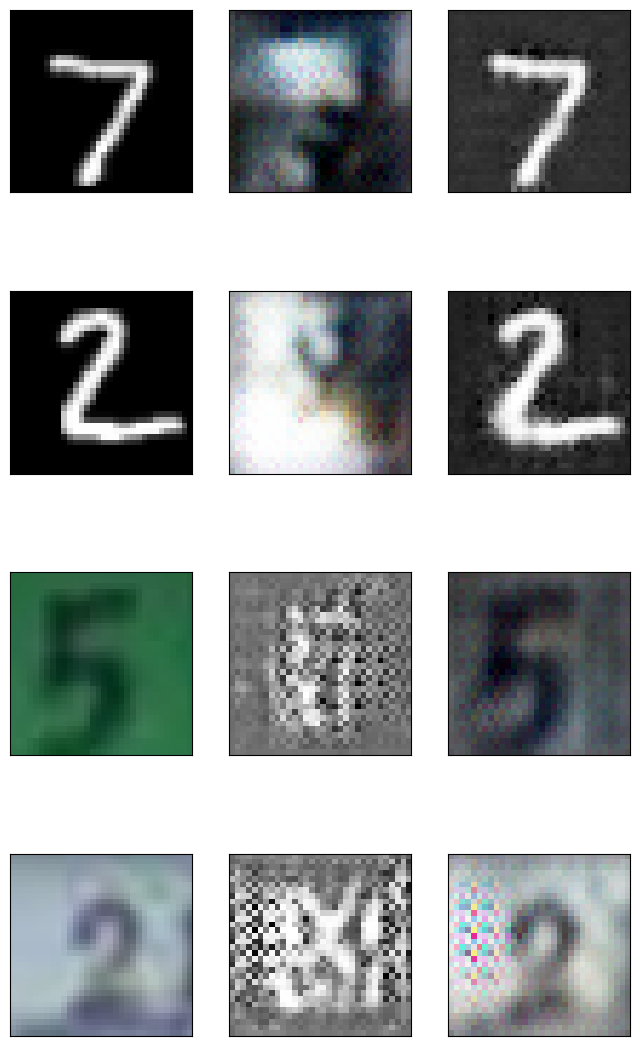

Step[10000/50000], d_real_loss: 0.0000, d_fake_loss: 0.0000, g_loss: 1.0097


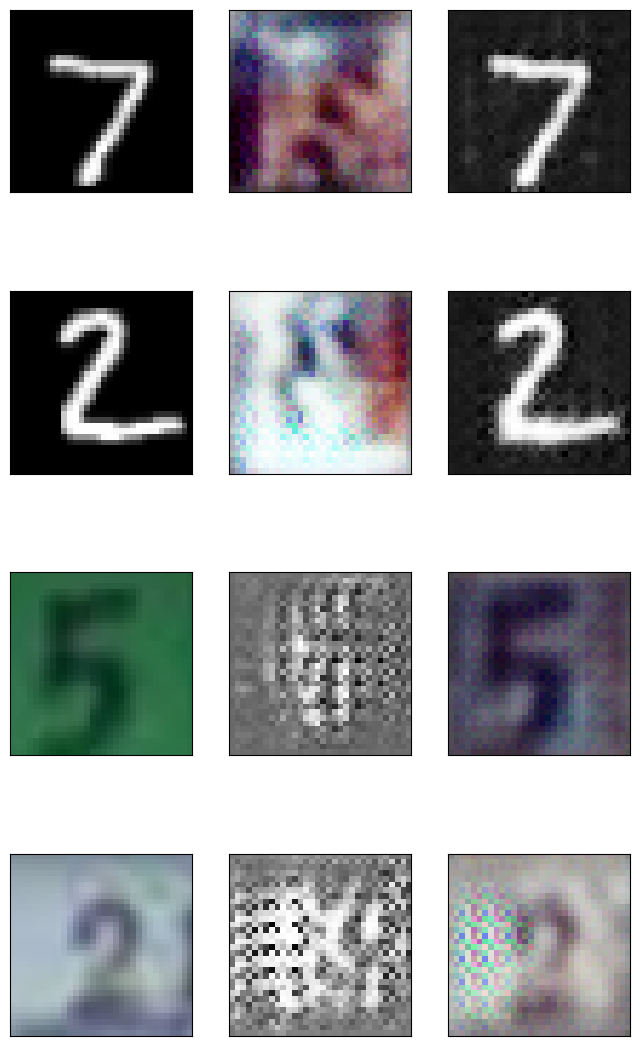

Step[11000/50000], d_real_loss: 0.0000, d_fake_loss: 0.0000, g_loss: 1.0289


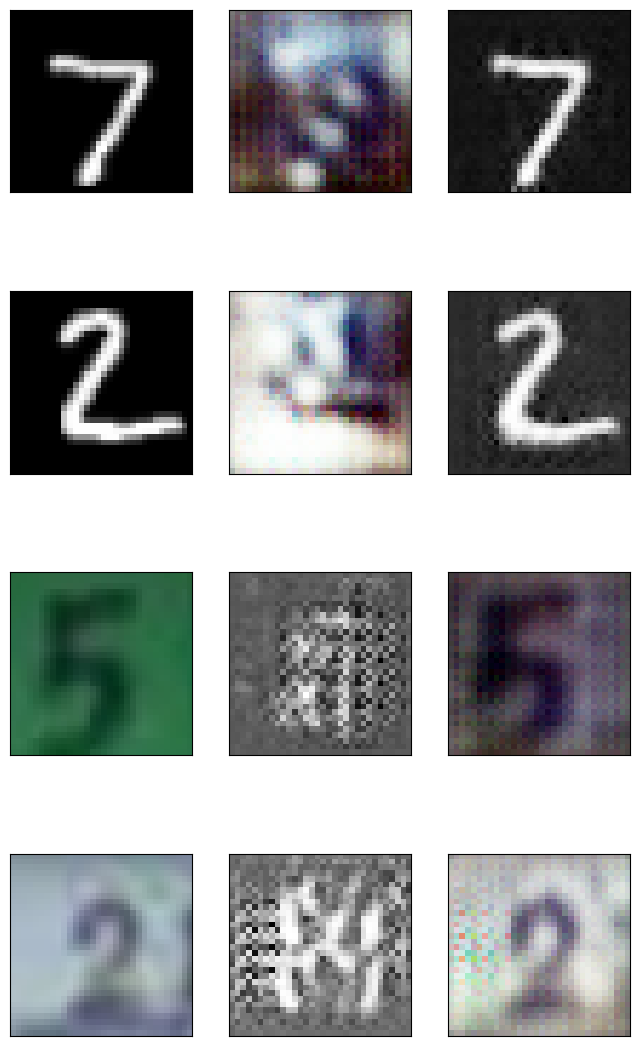

KeyboardInterrupt: 

In [9]:
# Iteration 수 선언
iters = 50000

# trainig 과정에서 생성되는 이미지가 어떻게 변화하는지 볼 수 있도록 고정된 데이터를 가지고 있으면 좋다.
mnist_iter = iter(mnist_testloader)
svhn_iter = iter(svhn_testloader)

# 각 도메인별로 2개만 생성해 보자.
fixed_mnist = next(mnist_iter)[0][:2].cuda()
fixed_svhn = next(svhn_iter)[0][:2].cuda()

D_loss_fake_data = []
D_loss_real_data = []
G_loss_data = []

for i in range(iters):
    # 각 도메인의 데이터들을 불러와 준다.
    try:
        mnist, m_labels = next(mnist_iter)
        svhn, s_labels = next(svhn_iter)
    except:
        mnist_iter = iter(mnist_testloader)
        svhn_iter = iter(svhn_testloader)
        mnist, m_labels = next(mnist_iter)
        svhn, s_labels = next(svhn_iter)

    # To GPU
    mnist = mnist.cuda()
    m_labels = m_labels.cuda()
    svhn = svhn.cuda()
    s_labels = s_labels.cuda()

    #============= Train the discriminator =============#

    # Real images를 통해 D를 트레이닝 한다.
    out = D_m(mnist)
    d_loss_mnist = torch.mean((out-1)**2)

    out = D_s(svhn)
    d_loss_svhn = torch.mean((out-1)**2)

    d_real_loss = d_loss_mnist + d_loss_svhn

    d_optimizer.zero_grad()
    d_real_loss.backward()
    d_optimizer.step()

    # Fake images = generated images를 통해 D를 트레이닝 한다.
    fake_svhn = G_ms(mnist)
    out = D_s(fake_svhn)
    d_loss_mnist = torch.mean(out**2)

    fake_mnist = G_sm(svhn)
    out = D_m(fake_mnist)
    d_loss_svhn = torch.mean(out**2)

    d_fake_loss = d_loss_mnist + d_loss_svhn

    d_optimizer.zero_grad()
    d_fake_loss.backward()
    d_optimizer.step()

    #=============== Train the generator ===============#

    # mnist-svhn-mnist cycle loss를 발생 시킨다.
    fake_svhn = G_ms(mnist)
    out = D_s(fake_svhn)
    recon_mnist = G_sm(fake_svhn)

    g_loss = torch.mean((out-1)**2) # Discriminator를 속이도록 gradient 정보가 흐를 수 있다.
    g_loss += torch.mean((mnist - recon_mnist)**2) # MNIST를 다시 만들어 내야 한다

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    # svhn-mnist-svhn loss를 발생 시킨다.
    fake_mnist = G_sm(svhn)
    out = D_m(fake_mnist)
    recon_svhn = G_ms(fake_mnist)

    g_loss = torch.mean((out-1)**2) # Discriminator를 속이도록 gradient 정보가 흐를 수 있다.
    g_loss += torch.mean((svhn - recon_svhn)**2) # SVHN를 다시 만들어 내야 한다.

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if (i+1) % 100 == 0:
        D_loss_fake_data.append(float(d_fake_loss.item()))
        D_loss_real_data.append(float(d_real_loss.item()))
        G_loss_data.append(float(g_loss.item()))

    # print the log info
    if (i+1) % 1000 == 0:
        # fixed image 로 이미지 생성
        mnist_to_svhn = G_ms(fixed_mnist)
        mnist_recon = G_sm(mnist_to_svhn)

        svhn_to_mnist = G_sm(fixed_svhn)
        svhn_recon = G_ms(svhn_to_mnist)

        print('======================================================================================================')
        print('Step[%d/%d], d_real_loss: %.4f, d_fake_loss: %.4f, g_loss: %.4f'
                  %(i+1, iters, d_real_loss.item(), d_fake_loss.item(), g_loss.item()))
        print('======================================================================================================')
        show_images([fixed_mnist.detach().cpu().numpy(), mnist_to_svhn.detach().cpu().numpy(), mnist_recon.detach().cpu().numpy()
                        ,fixed_svhn.detach().cpu().numpy(), svhn_to_mnist.detach().cpu().numpy(), svhn_recon.detach().cpu().numpy()])

> 위 시각화 이미지에서 첫 번째 이미지는 원본 사진, 두 번째 이미지는 변환 사진 (MNIST를 SVHN으로, 또는 SVHN을 MNIST로), 세 번째 이미지는 변환 사진을 원래 이미지로 reconstruction 한 결과이다.

In [ ]:
plt.plot(D_loss_fake_data, label='D_fake_loss')
plt.plot(D_loss_real_data, label='D_real_loss')
plt.plot(G_loss_data, label='G_loss')
plt.legend()
plt.show()

> Discriminator와 Generator loss를 plot한 결과는 위와 같다.

In [ ]:
!mkdir ./model
torch.save(G_ms.state_dict(),'./model/cyclegan_generator_ms.pckl')
torch.save(D_m.state_dict(),'./model/cyclegan_discriminator_m.pckl')
torch.save(G_sm.state_dict(),'./model/cyclegan_generator_sm.pckl')
torch.save(D_s.state_dict(),'./model/cyclegan_discriminator_s.pckl')